In [1]:
import os
from os import path as ospath
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from spiketools.plts.spikes import plot_firing_rates
from convnwb.io import open_h5file, get_files, load_config, save_json, load_json,make_session_name,load_nwbfile
from convnwb.paths import Paths

from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.utils.trials import recombine_trial_data
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.plts.spatial import plot_position_by_time,plot_heatmap,create_heatmap_title
from spiketools.spatial.occupancy import compute_occupancy,compute_trial_occupancy, compute_bin_edges,compute_bin_counts_pos, normalize_bin_counts
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.stats.shuffle import shuffle_circular,shuffle_bins
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.spatial.speed import compute_speed
from spiketools.plts.data import plot_hist, plot_bar, plot_lines
from spiketools.plts.annotate import add_vlines, add_hlines
from spiketools.plts.data import plot_polar_hist
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spikes import plot_waveform
from spiketools.stats.shuffle import shuffle_bins,shuffle_isis
from spiketools.plts.trials import plot_rasters
from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)

In [3]:
# Local imports
import sys
sys.path.append('../code')
from plts import plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key
from reports import create_sess_str
from group import get_all_session_paths
from models import create_df_place,fit_anova_place

# Settings 

In [4]:
base_path = "/Users/weijiazhang/Data/Train/nwbfiles"

In [5]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219c',
    'session' : '0'    
}

In [6]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219c_session_0'

# Load Data 

In [7]:
# Load NWB file
nwbfile = load_nwbfile(session, base_path)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


## Get unit data

In [8]:
# check available units 
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))
session['n_units'] = n_units

Number of unit: 23


In [9]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [10]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

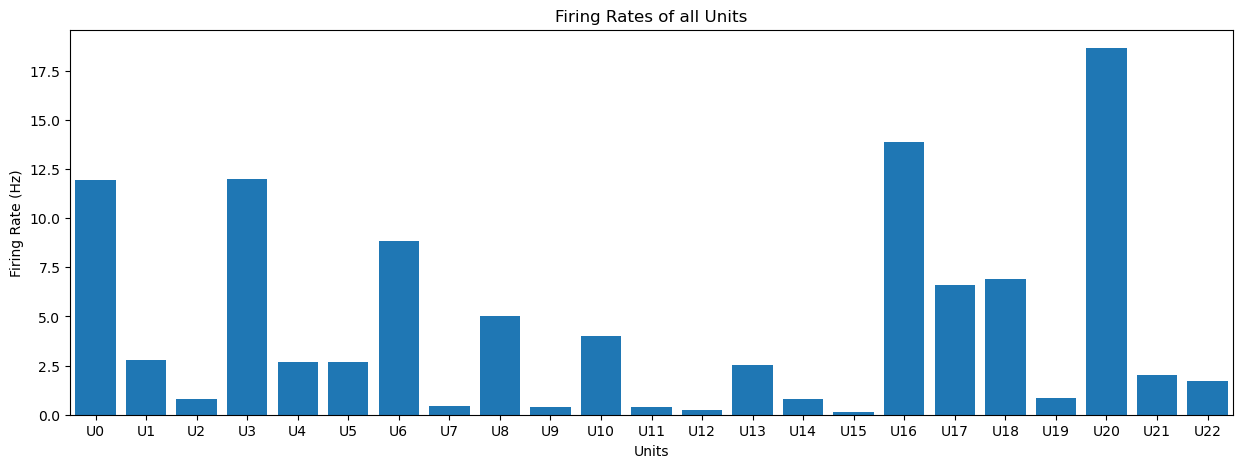

In [11]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

## Get position data 

In [12]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [13]:
# Compute position ranges
x_min_track, x_max_track = compute_pos_ranges(positions)
track_range = [x_min_track,x_max_track]
print('Min Track Position: ', x_min_track)
print('Max Track Position: ', x_max_track)
print('Track Range: ', track_range)

Min Track Position:  -33.9997
Max Track Position:  34.851
Track Range:  [-33.9997, 34.851]


In [14]:
# Binning 
num_bins =40
bins = np.linspace(x_min_track, x_max_track, num_bins+1)
bin_edges = compute_bin_edges(positions, num_bins)
bin_width = compute_bin_width(bin_edges)
print('Bin widths: {:1.2f}'.format(bin_width))

Bin widths: 1.72


In [15]:
bins

array([-33.9997   , -32.2784325, -30.557165 , -28.8358975, -27.11463  ,
       -25.3933625, -23.672095 , -21.9508275, -20.22956  , -18.5082925,
       -16.787025 , -15.0657575, -13.34449  , -11.6232225,  -9.901955 ,
        -8.1806875,  -6.45942  ,  -4.7381525,  -3.016885 ,  -1.2956175,
         0.42565  ,   2.1469175,   3.868185 ,   5.5894525,   7.31072  ,
         9.0319875,  10.753255 ,  12.4745225,  14.19579  ,  15.9170575,
        17.638325 ,  19.3595925,  21.08086  ,  22.8021275,  24.523395 ,
        26.2446625,  27.96593  ,  29.6871975,  31.408465 ,  33.1297325,
        34.851    ])

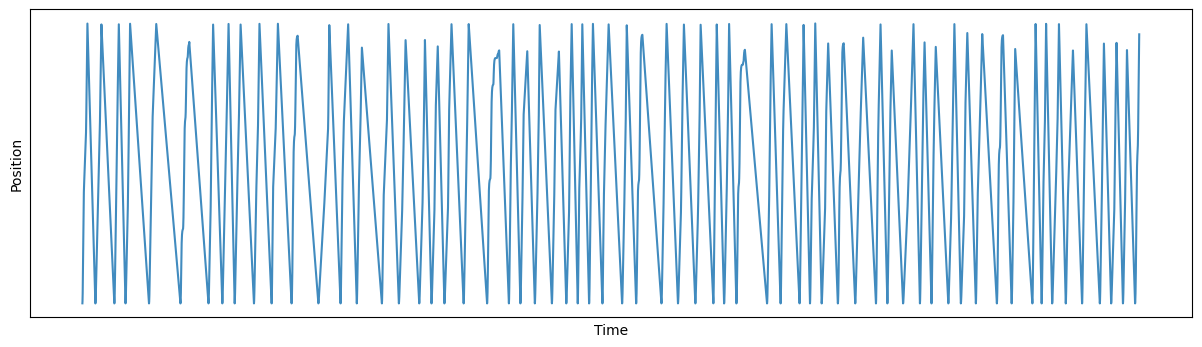

In [16]:
# Plot position across time
plot_position_by_time(ptimes, positions, alpha=0.85, figsize=(15, 4))

## Get Speed data

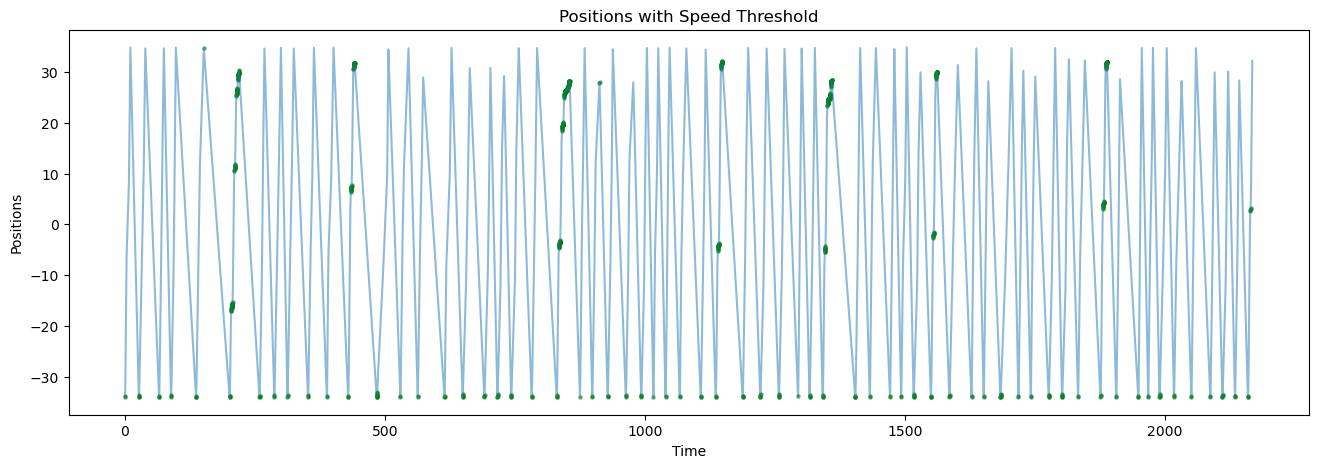

In [17]:
speed_thresh =2
speed = compute_speed(positions, ptimes)
plot_positions_with_speed(ptimes, positions, speed,speed_thresh)

## Get Trial Structure

In [18]:
start_time = nwbfile.trials['start_time']
stop_time = nwbfile.trials['stop_time']

trial_start = nwbfile.trials['movement_start_time']
trial_end = nwbfile.trials['movement_stop_time']

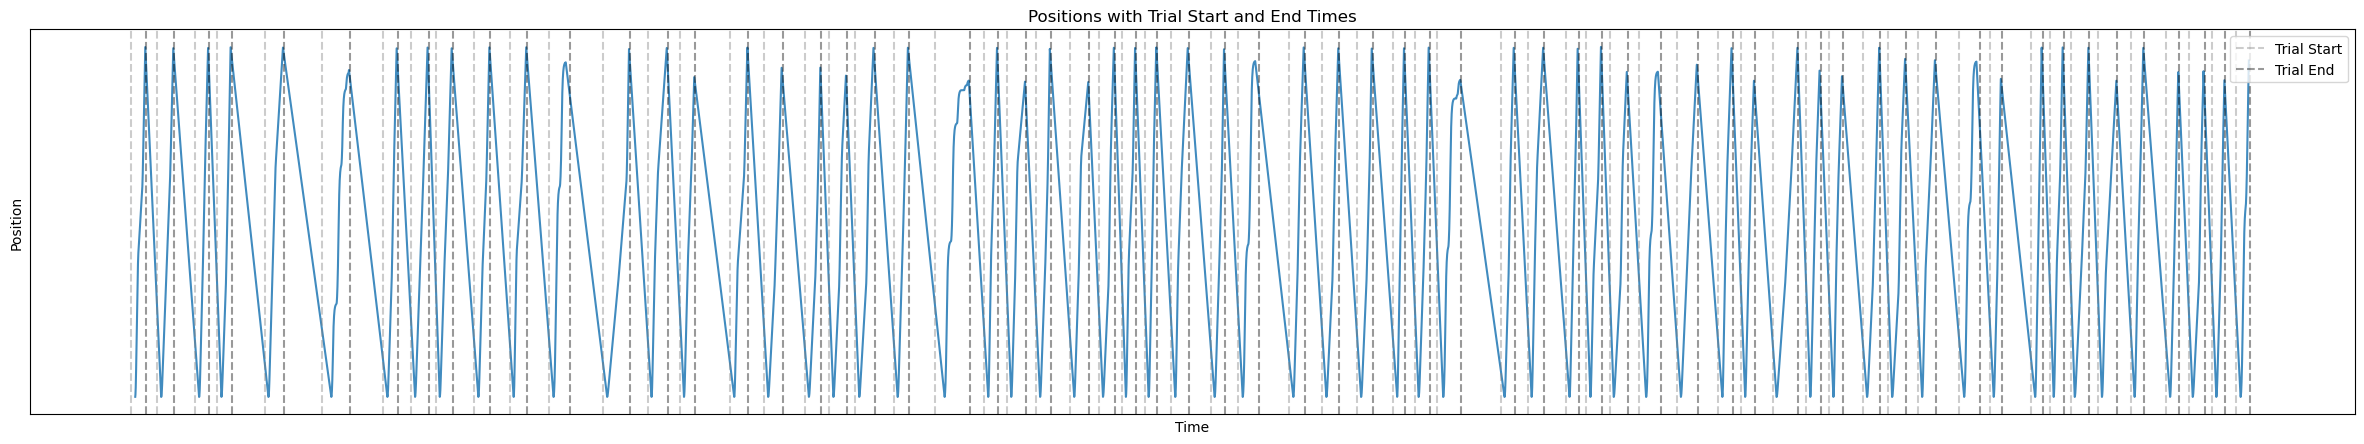

In [19]:
plot_position_by_time(ptimes, positions, alpha=0.85,figsize=(30, 5))

for start in trial_start:
    plt.axvline(x=start, color='grey', alpha=0.4, linestyle='--', label='Trial Start' if start == trial_start[0] else "")

# Scatter plot for 'trial_end' points
# Similar approach as for 'trial_start'
for end in trial_end:
    plt.axvline(x=end, color='black', alpha=0.4, linestyle='--', label='Trial End' if end == trial_end[0] else "")

# Add title, legend, and labels
plt.title('Positions with Trial Start and End Times')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

# Show the plot
plt.show()

# Occupancy 

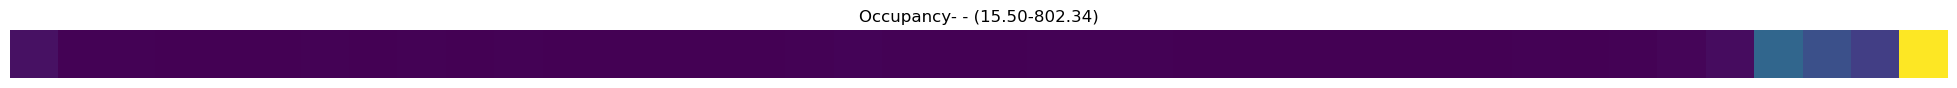

In [54]:
min_occ = .1
speed_thresh = 2
max_time = 0.25
occ = compute_occupancy(positions, ptimes, num_bins,min_speed=speed_thresh)
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), figsize=(25, 5))

# Single Unit 

In [55]:
# Extract spikes for a unit of interest
uind = 1
spikes = nwbfile.units.get_unit_spike_times(uind)
print(spikes.shape)



(6571,)


In [56]:
# Compute the firing rate per trial
spikes_trial = epoch_spikes_by_range(spikes, trial_start, trial_end, reset=True)
movement_spikes = []
frs = np.zeros(len(spikes_trial))
for ind in range(len(spikes_trial)): 
    t_spikes = get_range(spikes, trial_start[ind],trial_end[ind])
    movement_spikes.append(t_spikes)
    movement_spikes_all = np.concatenate(movement_spikes).ravel()
    
    frs[ind] = compute_firing_rate(spikes_trial[ind])

In [69]:
spikes = movement_spikes_all
print(spikes.shape)
spikes = threshold_spikes_by_values(spikes, ptimes, speed, speed_thresh)
print(spikes.shape)

(3085,)
(2742,)


In [70]:
spike_pos= get_values_by_times(ptimes, positions, spikes)
spike_positions = get_values_by_times(ptimes, positions, spikes)

In [71]:
spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
firing_rates = spike_counts / occ
spike_info = compute_spatial_information(firing_rates, occ)

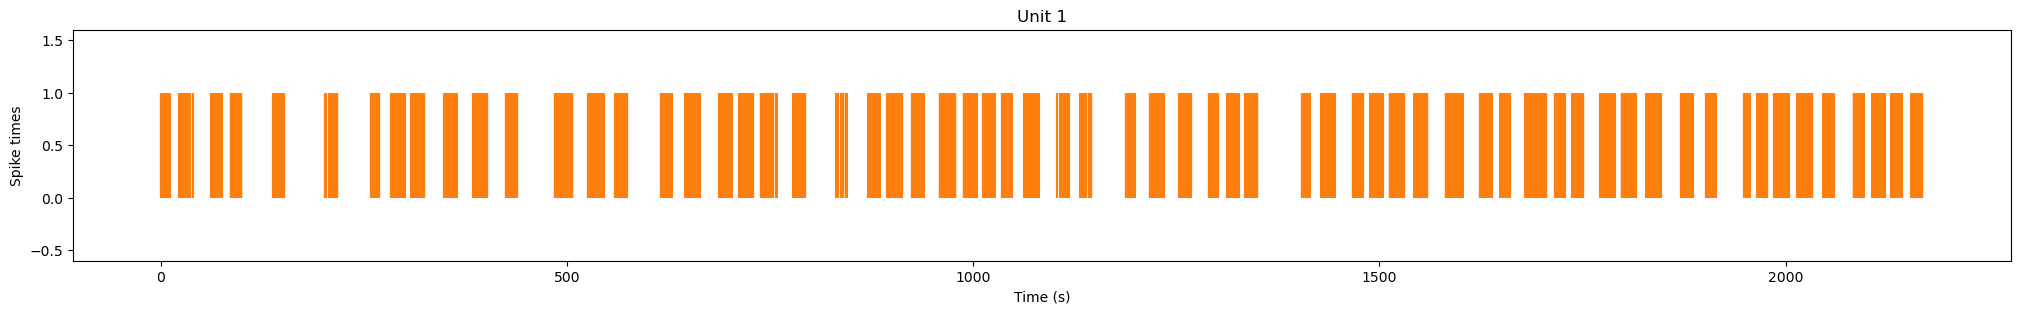

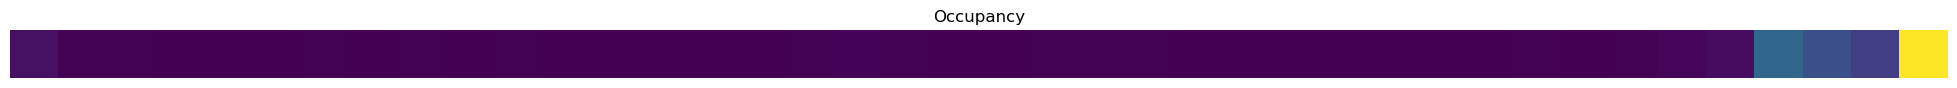

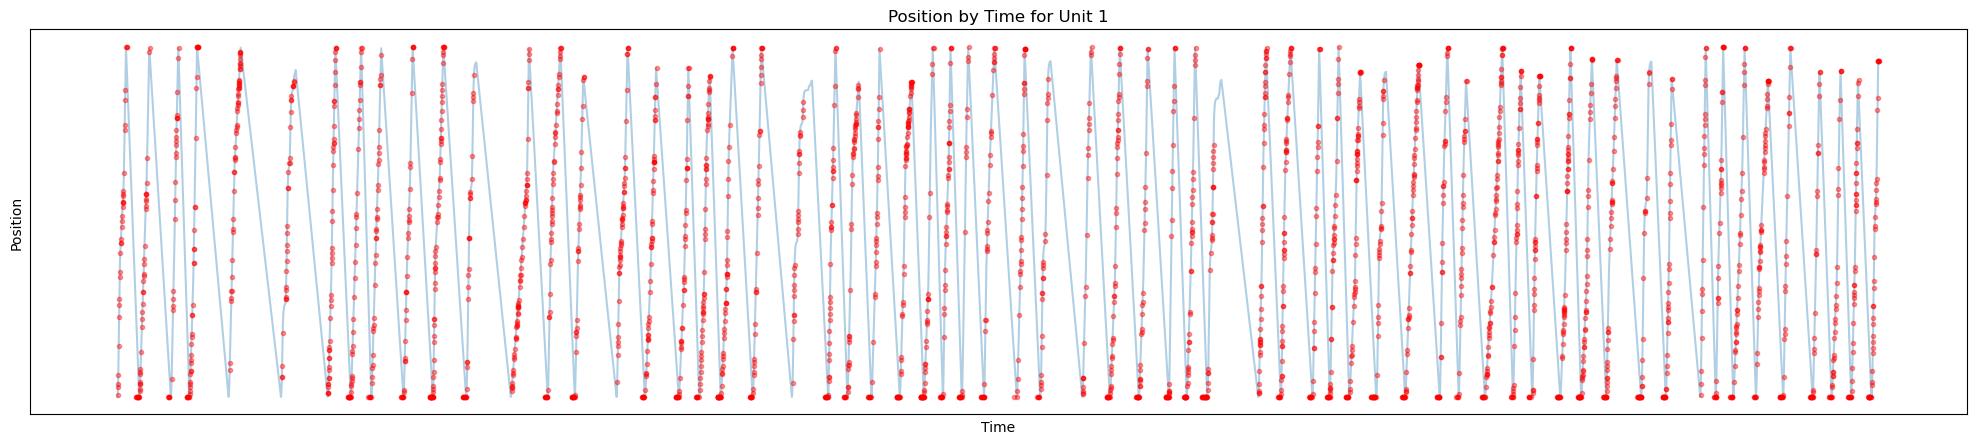

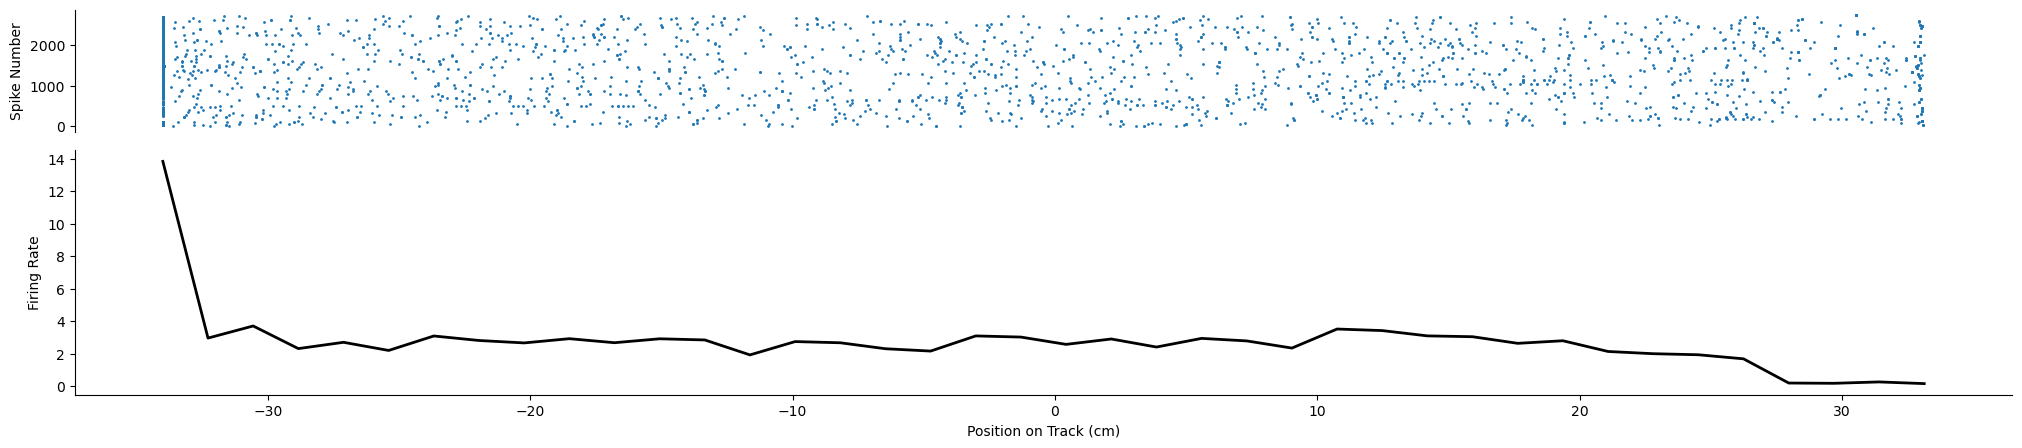

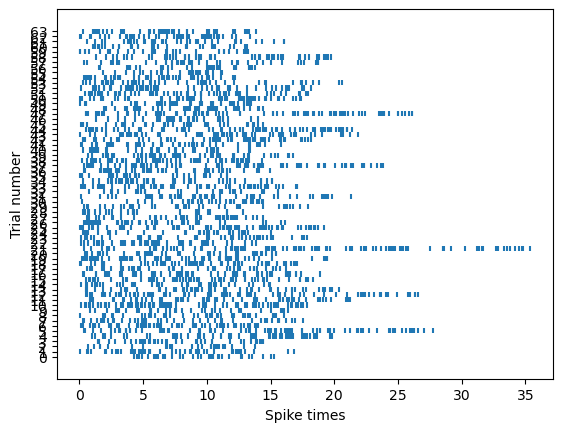

In [72]:
plt.figure(figsize=(25, 3))
plt.eventplot(spikes, lineoffsets=0.5, colors=f'C{uind}')
plt.xlabel('Time (s)')
plt.ylabel('Spike times')
plt.title(f'Unit {uind}')

plot_heatmap(occ, title="Occupancy", figsize=(25, 5))
plot_position_by_time(ptimes,positions,spikes,spike_pos, figsize=(25, 5))
plt.title(f'Position by Time for Unit {uind}')


fig, axs = plt.subplots(2, 1, figsize=(25, 5), gridspec_kw={'height_ratios': [1, 2],})
plt.subplots_adjust(hspace=0.1)  # Adjust the vertical spacing between subplots

# Raster plot
axs[0].scatter(spike_pos, np.arange(len(spike_pos)),s=1)
axs[0].set_ylabel('Spike Number')
axs[0].spines['top'].set_visible(False)  # Hide the top spine
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xticks([]) 

# Firing rate map
axs[1].plot( bins[:-1],firing_rates[:], 'k', lw=2)
axs[1].set_xlabel('Position on Track (cm)')
axs[1].set_ylabel('Firing Rate')
axs[1].spines['top'].set_visible(False)  # Hide the top spine
axs[1].spines['right'].set_visible(False)


plot_rasters(spikes_trial, show_axis=True,  xlabel='Spike times',
                 ylabel="Trial number", yticks=range(0, len(spikes_trial)))


# Statistics 

## Spatial Info

In [73]:
spike_info = compute_spatial_information(firing_rates, occ)
print(f'Spatial_Info: {np.round(spike_info,3)}')

Spatial_Info: 1.308


## ANOVA

In [74]:
# Step1: Get trial occupancy
trial_occupancy = compute_trial_occupancy(positions, ptimes, num_bins, trial_start, trial_end)

# Step2: Compute firing rate for each spatial bin for each trial
trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, num_bins, trial_start, trial_end,
                                         
                                            trial_occupancy=trial_occupancy, flatten=True)

# Step3: Create the data frame
df = create_df_place(trial_place_bins)


# Step4: Compute ANOVA f-value
f_val = fit_anova_place(df)
print('F value: ', round(f_val,3))

F value:  26.045


## Shuffle 

In [75]:
n_surrogates = 100
times_shuffle = shuffle_spikes(spikes, 'circular', n_shuffles=n_surrogates)

### Shuffle - Spike Info 

In [76]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    
  
    #spike_t = get_values_by_times(occ_ptimes, occ_ptimes, stimes)
    spike_p = get_values_by_times(ptimes, positions, stimes)

    spike_counts = compute_bin_counts_pos(spike_p, num_bins)
    bin_firing = spike_counts / occ
    
    surrs[ind] = compute_spatial_information(bin_firing, occ, normalize=True)

p-value: 1.00
z-score: -4.17


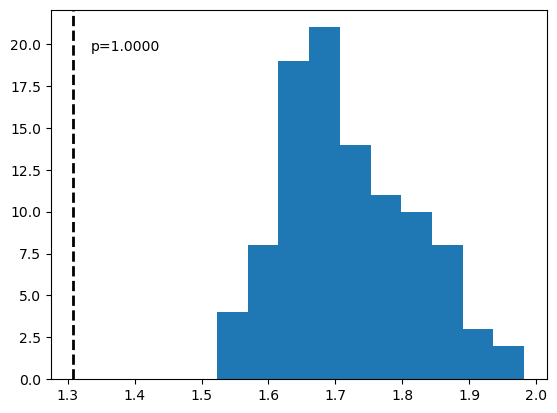

In [77]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True,plot = True)

### Shuffle - ANOVA 

In [78]:
# Compute spatial information measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    
    trial_place_bins = compute_trial_place_bins(stimes, positions, ptimes, num_bins, trial_start, trial_end,
                                         
                                            trial_occupancy=trial_occupancy, flatten=True)
    
    surrogates[ind] = fit_anova_place(create_df_place(trial_place_bins))

p-value: 0.00
z-score: 5.47


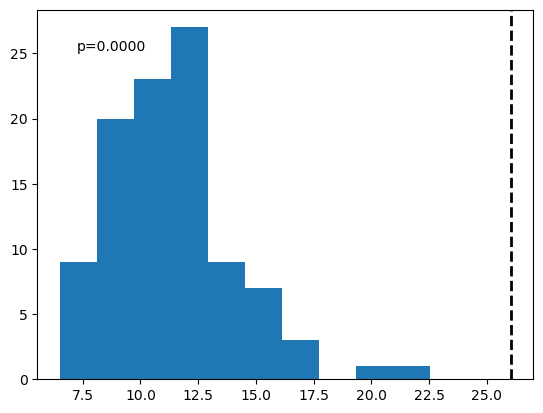

In [79]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True,plot = True)

# Report 

p-value: 1.00
z-score: -4.17
p-value: 0.00
z-score: 5.47


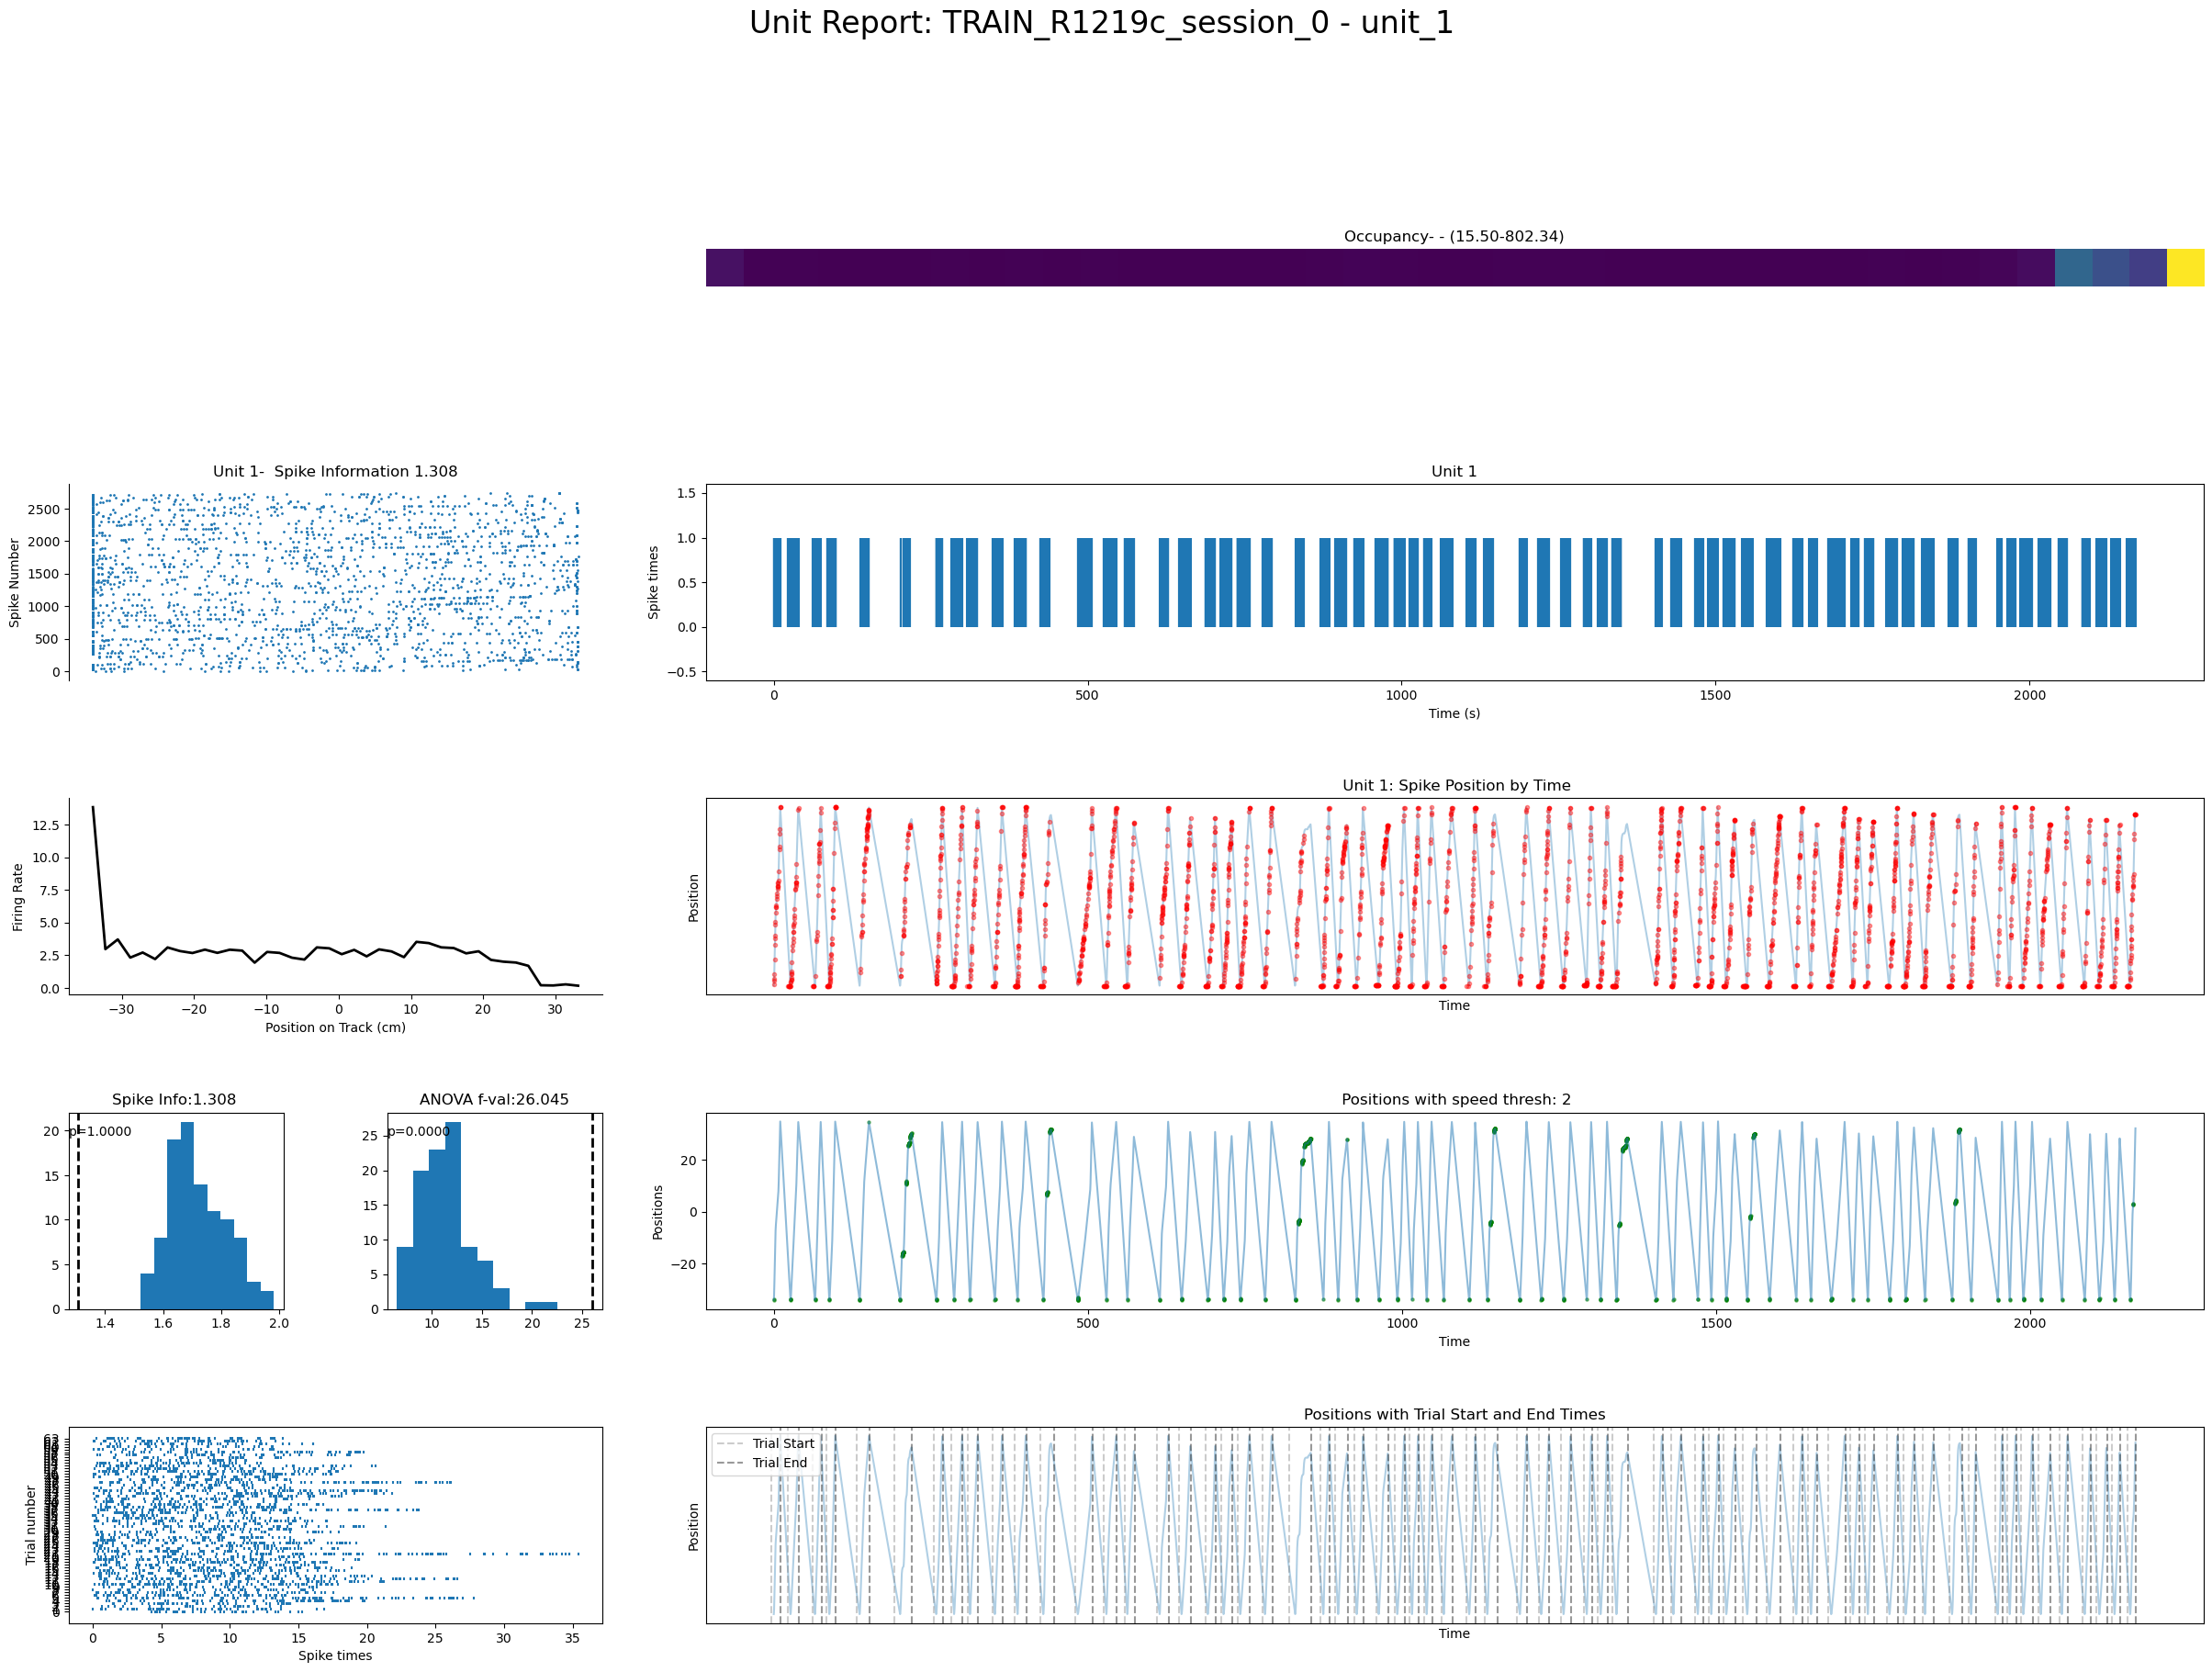

In [93]:
# Initialize figure with grid layout
grid = make_grid(6, 5, wspace=0.3, hspace=.6, figsize=(30, 25),
                 width_ratios=[0.5, .5, 1, 1, 1],
                 title=f'Unit Report: {session_name} - unit_{uind}')
#plot_text(create_sess_str(session), ax=get_grid_subplot(grid, 0, 0))
# plot_text(create_pos_str(summary), ax=get_grid_subplot(grid, 0, 1))
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), ax = get_grid_subplot(grid, slice(0, 1), slice(2, 5)))

ax = get_grid_subplot(grid, slice(1, 2), slice(2, 5))
ax.eventplot(spikes, lineoffsets=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike times')
ax.set_title(f'Unit {uind}')

plot_position_by_time(ptimes,positions,spikes,spike_pos, ax = get_grid_subplot(grid, slice(2, 3), slice(2, 5)))
plt.title(f' Unit {uind}: Spike Position by Time')

plot_positions_with_speed(ptimes, positions, speed,speed_thresh,ax = get_grid_subplot(grid, slice(3, 4), slice(2, 5)))
plt.title(f' Positions with speed thresh: {speed_thresh}')


plot_position_by_time(ptimes, positions, ax=get_grid_subplot(grid, slice(4,5), slice(2, 5)))
for start in trial_start:
    plt.axvline(x=start, color='grey', alpha=0.4, linestyle='--', label='Trial Start' if start == trial_start[0] else "")
for end in trial_end:
    plt.axvline(x=end, color='black', alpha=0.4, linestyle='--', label='Trial End' if end == trial_end[0] else "")
plt.title('Positions with Trial Start and End Times')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()


ax = get_grid_subplot(grid, slice(1, 2), slice(0, 2))
ax.scatter(spike_pos, np.arange(len(spike_pos)),s=1)
ax.set_title(f'Unit {uind}-  Spike Information {round(spike_info, 3)}')
ax.set_ylabel('Spike Number')
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([]) 

ax = get_grid_subplot(grid, slice(2,3), slice(0, 2))
ax.plot(bins[:-1], firing_rates, 'k', lw=2)
ax.set_xlabel('Position on Track (cm)')
ax.set_ylabel('Firing Rate')
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)

# # Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True,plot = True, ax = get_grid_subplot(grid,3,0))
plt.title(f'Spike Info:{np.round(spike_info,3)} ')
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True,plot = True, ax = get_grid_subplot(grid,3,1))
plt.title(f'ANOVA f-val:{np.round(f_val,3)}')

plot_rasters(spikes_trial,ax = get_grid_subplot(grid, slice(4, 5), slice(0, 2)), show_axis=True,  xlabel='Spike times',
                 ylabel="Trial number", yticks=range(0, len(spikes_trial)))